# **ML Models comparative analysis on Obesity - CVD risk data**

## 1. Briefing

|            |          |                     |
|------------|----------|---------------------|
| Subject    |          | Machine Learning    |
| Supervisor |          | Prof. Aswin Kannan  |
|            |          |                     |
| Team Name  |          | MT2025724_MT2025732 |
| Member 1   | Name:    | Shreya Gupta              |
|            | Roll No: | MT2025724           |
| Member 2   | Name:    | Anirudh Sharma              |
|            | Roll No: | MT2025732           |
|            |          |                     |

TODO: Add some numericals like the number of models compared, number of data processing techniques applied...

### Keywords

## 2. Summary

* 4–8 bullet points summarizing highest-level conclusions (best model(s), tradeoffs, recommended next steps).
* Short comparative table of winners by criteria (accuracy, latency, model size, fairness, etc.)

## 3. Introduction

* Problem statement and motivation
* Objectives of the comparative study (what questions you will answer)
* Scope (datasets, model families, compute constraints)
* Contributions (what unique analyses you provide — e.g., timing, memory profiling, calibration, fairness tests)


## System Imports

In [154]:
import chime
import random
import time
import json
import functools
import itertools
import warnings
import joblib
import inspect

import pandas as pd
import numpy as np
import scipy as sp
import sklearn as skl
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pprint import pprint
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import IPython.display as d

## Helper Functions

### Notification System Setup

In [2]:
# Set notification sound
chime.theme("material")
chime.info()

### PyPlot Setup

In [3]:
# Font Setup
font_suptitle = {'fontsize': 18, 'fontweight': "bold"}
font_title = {'fontsize': 14, 'fontweight': "bold"}
font_label = {'fontsize': 12}
font_ticks = {'fontsize': 10}

mpl.rcParams['font.family'] = 'monospace'
mpl.rcParams['axes.labelsize'] = font_label['fontsize']
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = font_ticks['fontsize']
mpl.rcParams['figure.titlesize'] = font_suptitle['fontsize']

max_fig_width = 11
sml_fig = (4, 3)
wid_fig = (8, 3)


# Optional<Function<Arg|Map, Unit>>
def compose(function, data_1, data_2: dict):
    if data_1 is not None:
        if isinstance(data_1, str):
            function(data_1, **data_2)
        elif isinstance(data_1, dict):
            data_2 = data_2.copy()
            data_2.update(data_1)
            function(**data_2)


# Font Embed Helpers
def annotate_plot(
        ax: plt.Axes,
        title: str = None,
        x_label: str = None, y_label: str = None,
        x_ticks=None, y_ticks=None,
) -> None:
    compose(ax.set_title, title, font_title)
    compose(ax.set_xlabel, x_label, font_label)
    compose(ax.set_ylabel, y_label, font_label)
    compose(ax.set_xticks, x_ticks, font_ticks)
    compose(ax.set_yticks, y_ticks, font_ticks)


def conclude_plot(suptitle: str = None, constrained=False):
    if constrained:
        fig.set_constrained_layout(True)
    else:
        plt.tight_layout()
    plt.savefig(f'report/figures/plot_{suptitle}.png', dpi=300)
    compose(plt.suptitle, suptitle, font_suptitle)
    if constrained:
        fig.set_constrained_layout(True)
    else:
        plt.tight_layout()
    plt.show()


def conclude_csv(ds: pd.DataFrame, name=None):
    if name is None:
        if isinstance(ds, pd.Series):
            name = ds.name
        else:
            raise NameError()
    ds.to_csv(f'report/tables/data_{name}.csv', index=False)


chime.info()

### Randomizer Setup

In [4]:
default_seed = 1114


def reset_seed(seed=default_seed):
    random.seed(seed)
    np.random.seed(seed)


chime.info()

### Presentor Setup

In [5]:
displayMD = lambda x: display(d.Markdown(x))
kv = lambda field, value: "**%s:** `%s`" % (field.strip(), str(value).strip())
header = lambda n, field: "%s %s" % ("#" * n, field)
quote = lambda field: "\n\n> %s" % field.replace("\n", "\n> ")
list_out = lambda title, list: header(4, "%s\n\n* %s" % (title, "\n* ".join(list)))

### Other Helpers

In [6]:
def flatten(obj):
    if hasattr(obj, '__iter__') and not isinstance(obj, str):
        if hasattr(obj[0], '__iter__') and not isinstance(obj[0], str):
            return list(itertools.chain.from_iterable(obj))
        return obj
    return [obj]

### Transformation Helpers

In [7]:
def pop_drop_column(data, columns=None):
    if isinstance(data, pd.DataFrame): data.drop(columns=columns, inplace=True)
    return columns, None


def pop_log_transform(data, base=np.e):
    return base, np.log(data) / np.log(base)


def pop_root_transform(data, exp=0.5):
    return exp, np.power(data, exp)


def pop_box_cox_transform(data):
    data, lam = sp.stats.boxcox(data)
    return lam, data


def pop_one_hot_encode(data, name=None):
    if isinstance(data, pd.Series) and name is None: name = data.name
    return np.unique(data), pd.get_dummies(data, name)


def pop_soft_ohe(data, split_points):
    produce = []
    produce.append((data < split_points[1]))
    for s, e in zip(split_points[0:-2], split_points[2:]):
        produce.append(data * (data > s) * (data < e))
    produce.append(data * (data > split_points[-2]))
    return split_points, produce


def pop_binarize(data):
    assert len(np.unique_counts(data)) == 2
    pri_val, data = data[0], data == data[0]
    if isinstance(data, pd.Series): data.name = "is_%s_%s" % (data.name, pri_val)
    return pri_val, data


def pop_standardize(data):
    mean, std = np.mean(data, axis=0), np.std(data, axis=0)
    return (mean, std), (data - mean) / std


def pop_minmax(data):
    min, max = np.min(data, axis=0), np.max(data, axis=0)
    return (min, max), (data - min) / (max - min)


def pop_ordinal_encode(data):
    uniques, encoded = np.unique(data, return_inverse=True)
    if isinstance(data, pd.Series): encoded = pd.Series(encoded, index=data.index, name=data.name)
    return uniques, encoded


def compose_pop(*pop_operations):
    pop_operations = flatten(pop_operations)

    def pop_composed(data):
        arguments = []
        for pop_operation in pop_operations:
            args, data = pop_operation(data)
            if data is None: continue
            arguments.append([pop_operation.__name__, args])
        return arguments, data

    return pop_composed


def pop_round(data, decimals=0):
    return decimals, np.round(data, decimals=decimals)


def pop_derived_features(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    data["BMI"] = data["Weight"] / (data["Height"] ** 2)
    data["Water_Intake_per_Meal"] = data["CH2O"] / (data["NCP"] + 1e-6)
    data["Activity_to_Tech_Ratio"] = data["FAF"] / (data["TUE"] + 0.1)
    data["Healthy_Lifestyle_Score"] = (data["FCVC"] * 0.3 + data["FAF"] * 0.3
                                       + data["CH2O"] * 0.4 - data["FAVC"].map({"yes": 1, "no": 0}))
    data["Has_FamilyRisk_and_FAVC"] = np.where(
        (data["FHWO"] == "yes") & (data["FAVC"] == "yes"), 1, 0)
    data["Calorie_Monitoring_Interaction"] = (data["SCC"].map({"yes": 1, "no": 0})
                                              * data["FAVC"].map({"yes": 1, "no": 0}))
    return None, data


def prepare_pop(pop_operation, *args):
    def pop_prepared(data):
        return pop_operation(data, *args)

    return pop_prepared


def to_ser_op(ds: pd.DataFrame, col, pop_operation, keep_col=False, out_ds=None):
    data = ds[col]
    if not keep_col: ds.drop(columns=flatten(col), inplace=True)
    arg, data = compose_pop(pop_operation)(data)
    if out_ds is not None: ds = out_ds
    if data is None: return arg, ds
    if isinstance(data, list):
        for idx, sample in enumerate(data):
            ds["%s_%d" % (col, idx)] = sample
    elif isinstance(data, pd.DataFrame):
        for column in data.columns:
            ds[column] = data[column]
    else:
        ds[col] = data
    return arg, ds


def select_pipeline_variation(pipeline, index):
    pipeline = pipeline.copy()
    pipeline[1] = [pipeline[1][index]]
    return pipeline


def apply_pipeline(ds: pd.DataFrame, pipeline, to_numpy=True):
    compulsory, permutable = pipeline[0], pipeline[1]
    ds = ds.copy()
    arguments = []
    for pop_operation, columns in compulsory:
        for column in columns:
            if (not isinstance(column, str)) or (column in ds.columns):
                arg, _ = to_ser_op(ds, column, pop_operation, keep_col=False)
                arguments.append(arg)
    if len(permutable) == 0:
        yield arguments, ds.to_numpy() if to_numpy else ds
    for permutation in permutable:
        ds_ans = ds.copy()
        perm_arguments = arguments.copy()
        for pop_operation, columns in permutation:
            for column in columns:
                if (not isinstance(column, str)) or (column in ds_ans.columns):
                    arg, _ = to_ser_op(ds_ans, column, pop_operation, keep_col=False)
                    perm_arguments.append(arg)
        yield perm_arguments, ds_ans.to_numpy() if to_numpy else ds

### Model Helpers

In [164]:
def save_model(model, path):
    joblib.dump(model, path)


def load_model(path):
    return joblib.load(path)


def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=sml_fig) # Using your predefined small figure size
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=labels, 
        yticklabels=labels,
        cbar=False
    )
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title, **font_title)
    plt.show()


def evaluate_model(model, train_x, train_y, test_x, test_y, name, target_names=None):
    model.fit(train_x, train_y)
    
    train_pred_y = model.predict(train_x)
    test_pred_y = model.predict(test_x)
    
    displayMD(header(3, f"Evaluation: {name}"))
    
    train_accuracy = accuracy_score(train_y, train_pred_y)
    test_accuracy = accuracy_score(test_y, test_pred_y)
    
    displayMD(header(4, kv('Train Accuracy', f"{train_accuracy:.4f}")))
    displayMD(header(4, kv('Val Accuracy', f"{test_accuracy:.4f}")))
    
    try:
        auc_score = None
        if len(np.unique(test_y)) == 2:
            test_prob_y = model.predict_proba(test_x)[:, 1]
            auc_score = roc_auc_score(test_y, test_prob_y)
        elif len(np.unique(test_y)) > 2 and hasattr(model, "predict_proba"):
             test_prob_y = model.predict_proba(test_x)
             auc_score = roc_auc_score(test_y, test_prob_y, multi_class='ovr', average='macro')
             
        if auc_score is not None:
             displayMD(header(4, kv('Test Multiclass ROC AUC Score (OVR)', f"{auc_score:.4f}")))
        
    except Exception as e:
        displayMD(f"**Note:** AUC score failed to calculate: {e}")
    
    if target_names is None:
        target_names = [str(x) for x in np.unique(test_y)]
        
    plot_confusion_matrix(test_y, test_pred_y, target_names, title=f"Confusion Matrix: {name}")
    
    return model


def save_submission(key, model, data_test_ids, data_test, encoder = None):
    ds_res = pd.DataFrame()
    ds_res['id'] = data_test_ids
    
    predictions = model.predict(data_test) 
    
    if encoder is not None:
        predictions = encoder.inverse_transform(predictions) 
        
    ds_res['WeightCategory'] = predictions
    
    ds_res.to_csv(f'submission_{key}.csv', index=False)

## Data Loading and Description

In [10]:
# Load data from train and test CSVs - train data is to be used for model training an dtesting, test is to be used for generatign the final predictions

ds_source = pd.read_csv("train.csv")
ds_test = pd.read_csv("test.csv")

ds_source.rename(columns={'family_history_with_overweight': 'FHWO'}, inplace=True)
ds_test.rename(columns={'family_history_with_overweight': 'FHWO'}, inplace=True)

chime.info()

In [18]:
displayMD(header(3, "**Training Data Head and Info**"))
d.display(ds_source.head())
ds_source.info()

### **Training Data Head and Info**

,id,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15533 entries, 0 to 15532
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              15533 non-null  int64  
 1   Gender          15533 non-null  object 
 2   Age             15533 non-null  float64
 3   Height          15533 non-null  float64
 4   Weight          15533 non-null  float64
 5   FHWO            15533 non-null  object 
 6   FAVC            15533 non-null  object 
 7   FCVC            15533 non-null  float64
 8   NCP             15533 non-null  float64
 9   CAEC            15533 non-null  object 
 10  SMOKE           15533 non-null  object 
 11  CH2O            15533 non-null  float64
 12  SCC             15533 non-null  object 
 13  FAF             15533 non-null  float64
 14  TUE             15533 non-null  float64
 15  CALC            15533 non-null  object 
 16  MTRANS          15533 non-null  object 
 17  WeightCategory  15533 non-null 

In [19]:
# Analyse basic data shape - input features and target column

n_samples_all, n_columns = ds_source.shape
n_features_raw = n_columns - 2  # id and targets

target_labels = ds_source['WeightCategory'].unique()
n_targets = len(target_labels)

displayMD(header(4, kv('Number of total samples', n_samples_all)))
displayMD(header(4, kv('Number of total columns', n_columns)))
displayMD(header(4, kv('Number of features', n_features_raw)))
displayMD(header(4, kv('Number of classes in target feature', n_targets)))

#### **Number of total samples:** `15533`

#### **Number of total columns:** `18`

#### **Number of features:** `16`

#### **Number of classes in target feature:** `7`

In [20]:
# Dictionary to replace column names with their full forms for better interpretability

column_full_names = {
    'id': 'Entity Identifier', 'Gender': 'Gender', 'Age': 'Age', 'Height': 'Height', 'Weight': 'Weight',
    'FHWO': 'Family History With Overweight', 'FAVC': 'High Caloric Food Consumption Freq.',
    'FCVC': 'Vegetables Consumption Freq.', 'NCP': 'Main Meals Count', 'CAEC': 'Consumption of Food Between Meals',
    'SMOKE': 'Smoke', 'CH2O': 'Consumption of Water Daily', 'CALC': 'Consumption of alcohol',
    'SCC': 'Calories Consumption Monitoring', 'FAF': 'Physical Activity Freq.', 'TUE': 'Time using Technology Devices',
    'MTRANS': 'Modes of Transportation Used', 'WeightCategory': 'Weight Category', }

In [21]:
info = pd.io.formats.info.DataFrameInfo(
    data=ds_source,
    memory_usage=None,
)
ds_info = pd.DataFrame(zip(info.ids, info.ids.map(column_full_names), info.non_null_counts, info.dtypes),
                       columns=['Column Name', 'Description', 'Non-Null Count', 'Data Type'])

In [22]:
displayMD(header(3, kv('Memory Usage', info.memory_usage_string)))
conclude_csv(ds_info, "dataset_info")
display(ds_info)

### **Memory Usage:** `2.1+ MB`

,Column Name,Description,Non-Null Count,Data Type
0,id,Entity Identifier,15533,int64
1,Gender,Gender,15533,object
2,Age,Age,15533,float64
3,Height,Height,15533,float64
4,Weight,Weight,15533,float64
5,FHWO,Family History With Overweight,15533,object
6,FAVC,High Caloric Food Consumption Freq.,15533,object
7,FCVC,Vegetables Consumption Freq.,15533,float64
8,NCP,Main Meals Count,15533,float64
9,CAEC,Consumption of Food Between Meals,15533,object


In [23]:
# Display column datatype-wise

gb_info_by_dtype = ds_info.groupby('Data Type')['Column Name'].apply(list)
ds_dtype = pd.DataFrame({
    t: items + [''] * (gb_info_by_dtype.map(len).max() - len(items))
    for t, items in gb_info_by_dtype.items()
})
conclude_csv(ds_dtype, "dataset_dtypes")
display(ds_dtype)

,int64,float64,object
0,id,Age,Gender
1,,Height,FHWO
2,,Weight,FAVC
3,,FCVC,CAEC
4,,NCP,SMOKE
5,,CH2O,SCC
6,,FAF,CALC
7,,TUE,MTRANS
8,,,WeightCategory


In [24]:
# Display first five rows of the data

conclude_csv(ds_source.head(5), "dataset_head")
display(ds_source.head(5))

,id,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [25]:
# Display statistical data analysis for both numerical and categorical columns

ds_describe = ds_source.describe(include='all')
conclude_csv(ds_describe, "dataset_describe")
display(ds_describe)

,id,Gender,Age,Height,Weight,FHWO,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
count,15533.000000,15533,15533.000000,15533.000000,15533.000000,15533,15533,15533.000000,15533.000000,15533,15533,15533.000000,15533,15533.000000,15533.000000,15533,15533,15533
unique,NaN,2,NaN,NaN,NaN,2,2,NaN,NaN,4,2,NaN,2,NaN,NaN,3,5,7
top,NaN,Male,NaN,NaN,NaN,yes,yes,NaN,NaN,Sometimes,no,NaN,no,NaN,NaN,Sometimes,Public_Transportation,Obesity_Type_III
freq,NaN,7783,NaN,NaN,NaN,12696,14184,NaN,NaN,13126,15356,NaN,15019,NaN,NaN,11285,12470,2983
mean,7766.000000,NaN,23.816308,1.699918,87.785225,NaN,NaN,2.442917,2.760425,NaN,NaN,2.027626,NaN,0.976968,0.613813,NaN,NaN,NaN
std,4484.135201,NaN,5.663167,0.087670,26.369144,NaN,NaN,0.530895,0.706463,NaN,NaN,0.607733,NaN,0.836841,0.602223,NaN,NaN,NaN
min,0.000000,NaN,14.000000,1.450000,39.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,3883.000000,NaN,20.000000,1.630927,66.000000,NaN,NaN,2.000000,3.000000,NaN,NaN,1.796257,NaN,0.007050,0.000000,NaN,NaN,NaN
50%,7766.000000,NaN,22.771612,1.700000,84.000000,NaN,NaN,2.342220,3.000000,NaN,NaN,2.000000,NaN,1.000000,0.566353,NaN,NaN,NaN
75%,11649.000000,NaN,26.000000,1.762921,111.600553,NaN,NaN,3.000000,3.000000,NaN,NaN,2.531456,NaN,1.582675,1.000000,NaN,NaN,NaN


**Inference**

The statistical summary reveals a complete dataset with no missing values across all 18 features (count 15,533). Numerical features, notably Weight (range 39.0 to 165.1 kg), exhibit varying scales and likely skewness, necessitating scaling and potential transformation (e.g., log) to standardize ranges for modeling. Categorical columns show significant class imbalance (e.g., $98.8\%$ 'no' for SMOKE), and the target variable, WeightCategory, is a seven-class classification problem that requires Label Encoding and suggests the need for stratified cross-validation and class weighting during model evaluation to achieve robust performance across all risk categories.

In [26]:
# Separate out the various categories of features

redundant_columns = ['id']
target_columns = ['WeightCategory']

gaussian_features = ['Age', 'Height', 'Weight']
partial_features = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
binary_features = ['Gender', 'FHWO', 'FAVC', 'SMOKE', 'SCC']
nary_features = ['CAEC', 'CALC', 'MTRANS']

numerical_features = gaussian_features + partial_features
categorical_features = binary_features + nary_features
all_features = numerical_features + categorical_features

numerical_derived_features = ["BMI", "Water_Intake_per_Meal", "Activity_to_Tech_Ratio", "Healthy_Lifestyle_Score"]
binary_derived_features = ["Has_FamilyRisk_and_FAVC", "Calorie_Monitoring_Interaction"]
derived_features = numerical_derived_features + binary_derived_features

label_encoder = {label: index for index, label in enumerate(target_labels)}
label_decoder = {index: label for index, label in enumerate(target_labels)}

## Exploratory Data Analysis

#### Missing Value Detection

In [27]:
ds_missing = ds_source.isnull().sum().to_frame(name='Missing_Count')
conclude_csv(ds_missing, "eda_missing_counts")
display(ds_missing)

,Missing_Count
id,0
Gender,0
Age,0
Height,0
Weight,0
FHWO,0
FAVC,0
FCVC,0
NCP,0
CAEC,0


**Observation**: There is not a single missing value in any of the columns

**Inference**: The dataset is pretty good in this department! We do not have to perform any sorts of missing value handling procedures like removal, imputation or flagging.

#### Outlier Detection

In [28]:
    # Find number of values below or above the IQR

    def count_outliers(ds: pd.DataFrame, column: str):
        quan25 = ds[column].quantile(0.25)
        quan75 = ds[column].quantile(0.75)
        iqr = quan75 - quan25
        lower_limit = quan25 - 1.5 * iqr
        upper_limit = quan75 + 1.5 * iqr
        return len(ds[(ds[column] > upper_limit) | (ds[column] < lower_limit)])


    _ds_num = ds_source[numerical_features]
    ds_outliers = pd.DataFrame(zip(_ds_num.columns, [count_outliers(_ds_num, col) for col in _ds_num.columns]),
                            columns=['', 'Outliers_Count'])
    conclude_csv(ds_outliers, "eda_outlier_counts")
    display(ds_outliers)

,,Outliers_Count
0,Age,792
1,Height,4
2,Weight,0
3,FCVC,0
4,NCP,4548
5,CH2O,0
6,FAF,0
7,TUE,0


**Observation**: Age and NCP has a significant number of values outside the IQR

**Inference**: A lot of values outside of the IQR might indicate a possible issue in the data distribution since dropping or imputing such huge percentage of values, isn't recommended.

#### Feature Distribution

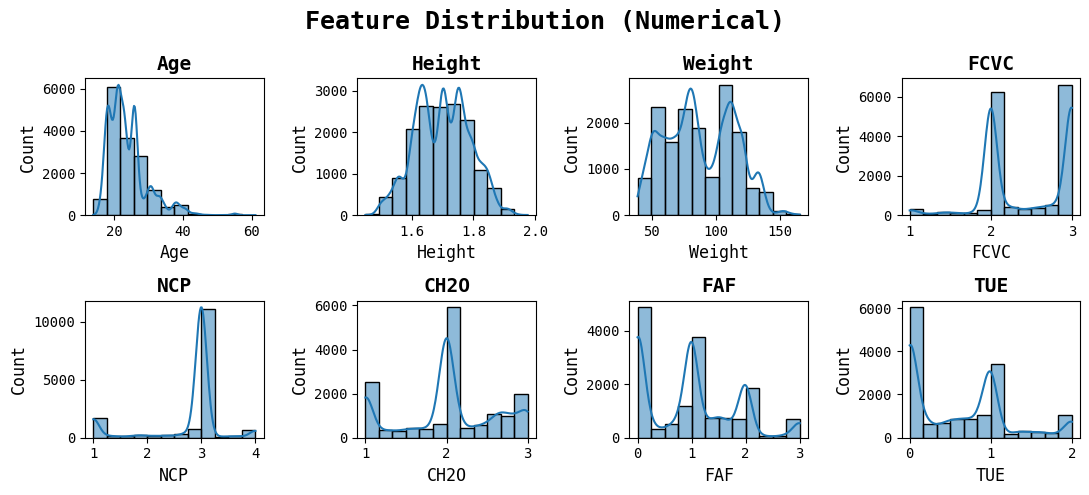

In [29]:
# Feature distribution plots for each of the numerical features

fig, axs = plt.subplots(2, 4, figsize=(max_fig_width, 5))
for ax, col in zip(flatten(axs), numerical_features):
    sns.histplot(ds_source[col], kde=True, bins=12, ax=ax)
    annotate_plot(ax, col)
conclude_plot("Feature Distribution (Numerical)")

**Observation**:
* Age is moderately right-skewed, with the bulk of the data clustered between roughly 18 and 30 years old.
* Height and Weight follow a somewhat traditional, unimodal distribution but show signs of slight multimodality in the case of Weight.
* All features other than Age, Height, and Weight (FCVC, NCP, CH20, FAF, TUE) exhibit clear multimodality, with peaks centered around specific, distinct values.
* FAF (Physical Activity) is heavily right-skewed, showing a significant frequency of low or zero activity.

**Inference**: The dataset contains a mix of standard continuous-like features (Age, Height, Weight) and several features that appear to be categorical or ordinal measures (FCVC, NCP, CH20, TUE) where responses cluster at specific points.

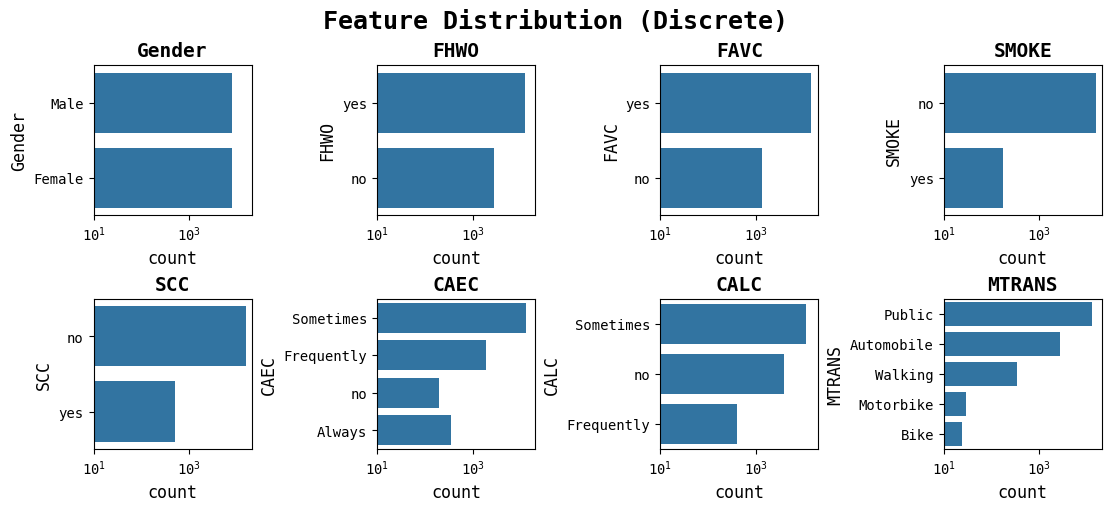

In [30]:
# Feature distribution plots for each of the categorical features

fig, axs = plt.subplots(2, 4, figsize=(max_fig_width, 5))
for ax, col in zip(flatten(axs), categorical_features):
    sns.countplot(ds_source[col], ax=ax)
    annotate_plot(ax, col), ax.set_xscale('log'), ax.set_xlim(10, 20000)
    if col == 'MTRANS': ax.set_yticks(range(5), ['Public', 'Automobile', 'Walking', 'Motorbike', 'Bike'], **font_ticks)
conclude_plot("Feature Distribution (Discrete)", constrained=True)

**Observation**:
* Gender is very well distributed; the counts for Male and Female are nearly equal.
* Family History With Overweight (FHWO) and High Caloric Food Consumption Freq (FAVC) have a moderate skewedness, with 'yes' counts being significantly higher than 'no'.
* Smoke (SMOKE) and Calories Consumption Monitoring (SCC) show strong skewedness, with 'no' responses dominating 'yes' responses (SCC is more skewed than SMOKE).
* Consumption of Food Between Meals (CAEC), Consumption of alcohol (CALC), and Means of Transportation Used (MTRANS) are highly heterogeneous/multi-category skewed, where counts are spread across multiple categories with one or two dominant levels (e.g., 'Sometimes' for CAEC, 'Public' for MTRANS).

**Inference**:
* The dataset is primarily composed of individuals with a family history of overweight and who frequently consume high-caloric foods. However, they do not typically smoke or monitor their calorie consumption. Furthermore, the majority rely on public transport or automobiles and consume alcohol only sometimes or not at all.

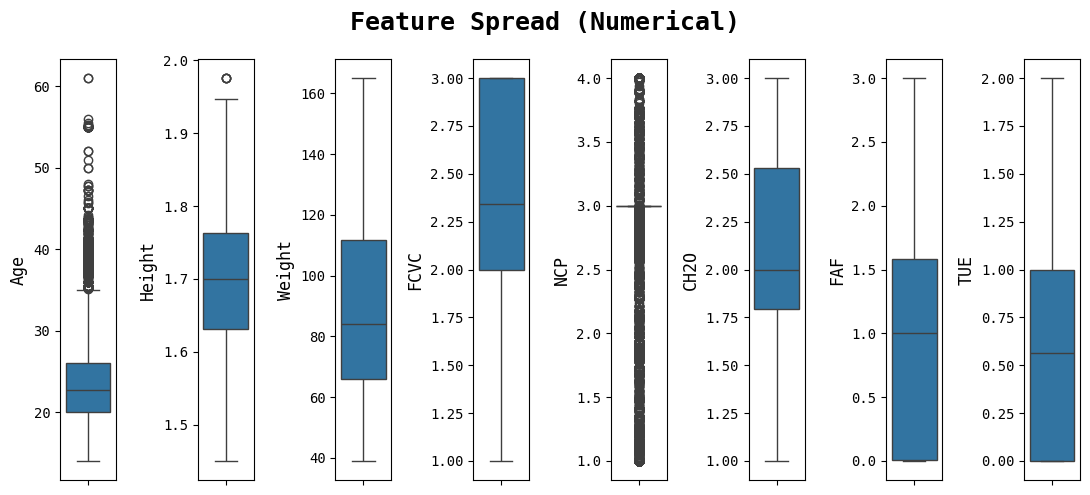

In [31]:
# Plots for analysing the feature spread of the numerical columns

fig, axs = plt.subplots(1, 8, figsize=(max_fig_width, 5))
for ax, column in zip(flatten(axs), numerical_features):
    sns.boxplot(y=column, data=ds_source, ax=ax)
conclude_plot("Feature Spread (Numerical)")

**Observation**:
* Age exhibits significant outliers extending up to the early 60s, while the interquartile range (IQR) is very tight, concentrated between roughly 20 and 24.
* Height and Weight show symmetrical spread and a clean distribution with minimal or no significant outliers.
* NCP (Number of Main Meals) has an extremely small IQR (median and quartiles are near 3) but contains numerous outliers spanning its entire range from 1 to 4.
* FCVC, CH20, FAF, and TUE have large interquartile ranges (IRQs) relative to their total range, indicating a wide spread of data across the possible values. TUE (Time Using Technology) is highly skewed, with the median near the bottom of the box.

**Inference**:
* The dataset's numerical features are generally well-contained but show distinct issues: Age and NCP are primarily characterized by a high number of outliers against a very concentrated central body, while the other features show a generally even, broad spread of values.

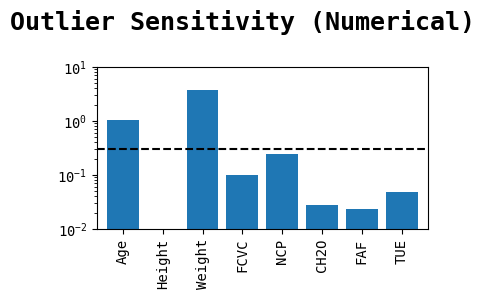

In [32]:
# Plot for analysing the sensitivity of the numerical features to outliers

plt.figure(figsize=sml_fig)
_ds_num = ds_source[numerical_features]
(_ds_num.mean() - _ds_num.median()).abs().plot(kind='bar', width=0.8)
plt.yscale('log'), plt.ylim(0.01, 10)
plt.axhline(0.3, color='black', linestyle='--')
conclude_plot("Outlier Sensitivity (Numerical)")

**Observation**:
* Weight and Age exhibit the highest outlier sensitivity, significantly exceeding the dashed baseline, indicating extreme values heavily influence their statistics. Height shows near-zero sensitivity, while the remaining features (FCVC, NCP, CH20, FAF, TUE) all fall well below the baseline.

**Inference**:
* Weight and Age are the two features most vulnerable to distortion by outliers and will require the most attention during the data preprocessing or cleaning phase. Conversely, Height is highly robust, and the other features are relatively stable against extreme values.

## Data Pre-Processing

### Handling 'Age' Feature

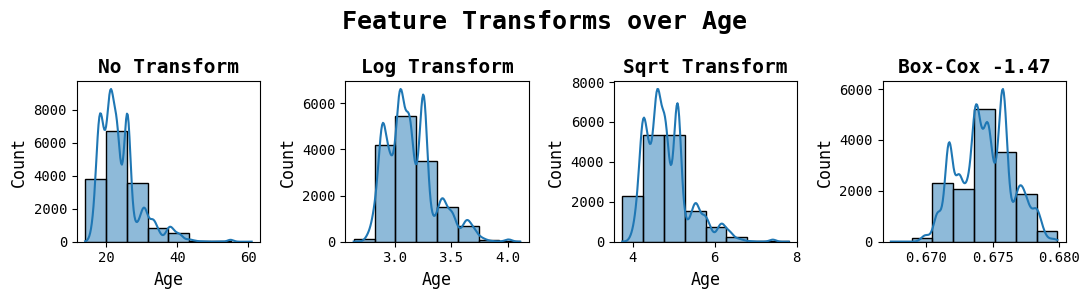

In [33]:
# Analysing the impact of various data transformation techniques on 'Age' feature in the dataset

fig, axs = plt.subplots(1, 4, figsize=(max_fig_width, 3))
_bclam, _bcage = pop_box_cox_transform(ds_source['Age'])
for ax, title, data in zip(flatten(axs), *zip(
        ['No Transform', ds_source['Age']],
        ['Log Transform', pop_log_transform(ds_source['Age'])[1]],
        ['Sqrt Transform', pop_root_transform(ds_source['Age'])[1]],
        ['Box-Cox %.2f' % _bclam, _bcage],
)):
    sns.histplot(data, kde=True, bins=8, ax=ax)
    annotate_plot(ax, title)
conclude_plot("Feature Transforms over Age")

**Observation** 

The Age feature is originally multimodal and heavily right-skewed. Both the Log and Sqrt transforms reduce skewness but fail to normalize the distribution effectively. The Box-Cox Transform with $\lambda = -1.47$ is the most successful at achieving a symmetrical shape.

**Inference**

The Box-Cox transformation with $\lambda = -1.47$ is the optimal choice for preprocessing the Age feature, as it best corrects the skewness and shifts the distribution closest to a more normalized form suitable for modeling.

### Handling 'NCP' Feature

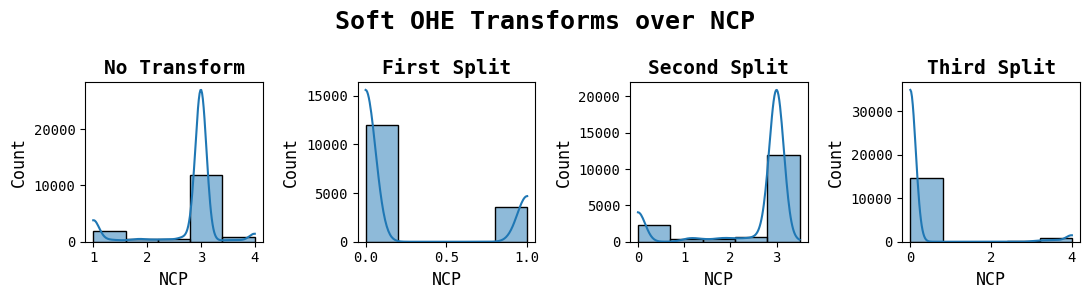

In [34]:
fig, axs = plt.subplots(1, 4, figsize=(max_fig_width, 3))
_, _scd_ncp = pop_soft_ohe(ds_source['NCP'], [1, 3, 3.5])
for ax, title, data in zip(flatten(axs), *zip(
        ['No Transform', ds_source['NCP']],
        ['First Split', _scd_ncp[0]],
        ['Second Split', _scd_ncp[1]],
        ['Third Split', _scd_ncp[2]],
)):
    sns.histplot(data, kde=True, bins=5, ax=ax)
    annotate_plot(ax, title)
conclude_plot("Soft OHE Transforms over NCP")

**Observation**

The visual analysis confirms that the original NCP (Main Meals Count) feature is highly discrete and clustered, overwhelmingly dominated by the value 3. The Soft OHE Transforms (Split 1, 2, and 3) do not produce a Gaussian or uniform distribution; instead, they primarily create step-function binaries that distinguish the dominant value from the remaining counts. This suggests the transformation is not effectively smoothing the distribution.

**Inference**

While the Soft OHE Transform visually appears suboptimal compared to a simple integer-to-dummy variable encoding, it creates three novel numerical features that capture complex, potentially non-linear thresholds ($<1$, $1-3$, $>3.5$). Since the predictive value of these non-linear feature combinations can only be confirmed empirically by the model, we will retain the Soft OHE as a preprocessing option. This approach allows the model to test whether these derived splits offer a performance advantage over standard One-Hot Encoding in separating the final risk categories.

## Data Pipelining

#### For Regression Based Models

In [42]:
regression_pipeline = [
    [  # Compulsory ones
        (pop_drop_column, ['id', 'WeightCategory']),
        (pop_binarize, binary_features),
        (pop_one_hot_encode, nary_features),
    ],
    [  # Permutable ones
        [],
        [  # Simple Life
            (pop_box_cox_transform, ['Age']),
            (pop_standardize, numerical_features),
        ],
        [  # Encoded Q-Conts
            (pop_box_cox_transform, ['Age']),
            (pop_standardize, gaussian_features),
            (pop_round, partial_features),
            (pop_one_hot_encode, partial_features),
        ],
        [  # Soft Hot Encode
            (pop_box_cox_transform, ['Age']),
            (pop_standardize, gaussian_features),
            (prepare_pop(pop_soft_ohe, [1, 2, 3]), ['FCVC']),
            (prepare_pop(pop_soft_ohe, [1, 3, 4]), ['NCP']),
            (prepare_pop(pop_soft_ohe, [1, 2, 3]), ['CH2O']),
            (prepare_pop(pop_soft_ohe, [0, 1, 2, 3]), ['FAF']),
            (prepare_pop(pop_soft_ohe, [0, 1, 2]), ['TUE']),
        ],
    ],
]
regression_pipeline_derived = regression_pipeline.copy()
regression_pipeline_derived[0] = [  # Compulsory ones
    (pop_drop_column, ['id', 'WeightCategory']),
    (pop_derived_features, [all_features]),
    (pop_binarize, binary_features),
    (pop_one_hot_encode, nary_features),
    (pop_standardize, numerical_derived_features),
    (pop_binarize, binary_derived_features),
]

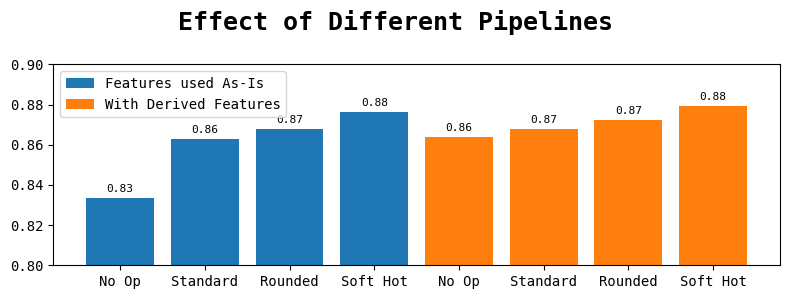

In [44]:
# Evaluation of logistic regression model (with default parameters) on different pipelines

_ds_targets = pop_ordinal_encode(ds_source['WeightCategory'])[1].to_numpy()
_scores = []

for pipeline in [regression_pipeline, regression_pipeline_derived]:
    for args, ds_sample in apply_pipeline(ds_source, pipeline):
        model = skl.linear_model.LogisticRegression(max_iter=1000)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=skl.exceptions.ConvergenceWarning)
            model.fit(ds_sample, _ds_targets)
        _scores.append(model.score(ds_sample, _ds_targets))

plt.figure(figsize=wid_fig)
bar_positions = range(len(_scores))
plt.bar(range(4), _scores[:4], label='Features used As-Is')
plt.bar(range(4, 8), _scores[4:], label='With Derived Features')
for i, score in enumerate(_scores):
    plt.text(i, score + 0.002, f'{score:.2f}', ha='center', va='bottom', fontsize=8)
plt.xticks(range(len(_scores)), ['No Op', 'Standard', 'Rounded', 'Soft Hot'] * 2)
plt.ylim(min(0.8, np.min(_scores)), max(0.9, np.max(_scores)))
plt.legend()
conclude_plot("Effect of Different Pipelines")

**Observation**

The Soft OHE transformation yields the highest and identical accuracy ($\approx 0.88$) for both the "Features used As-Is" and the "With Derived Features" groups. All other preprocessing methods show the "With Derived Features" group slightly outperforming the "As-Is" group, but the overall top score is achieved with Soft OHE.

**Inference**

The Soft OHE technique appears to be the most robust and effective preprocessing method, as it maximizes the model's performance regardless of whether complex derived features are included or not. Since the derived features do not provide an additional lift when using the best transformation (Soft OHE), the optimal and simplest final pipeline should focus on applying Soft OHE to the base features, maximizing performance while minimizing feature engineering complexity.

#### For Tree Based Models

In [40]:
tree_pipeline = [
    [  # Compulsory ones
        (pop_binarize, binary_features),
        (pop_drop_column, ['id', 'WeightCategory']),
    ],
    [  # Permutable ones
        [  # Ordinal Encoded
            (pop_ordinal_encode, nary_features),
        ],
        [  # One Hot Encoded
            (pop_one_hot_encode, nary_features),
        ],
    ],
]
tree_pipeline_derived = tree_pipeline.copy()
tree_pipeline_derived[0] = [  # Compulsory ones
    (pop_drop_column, ['id', 'WeightCategory']),
    (pop_derived_features, [all_features]),
    (pop_binarize, binary_features),
    (pop_standardize, numerical_derived_features),
    (pop_binarize, binary_derived_features),
]

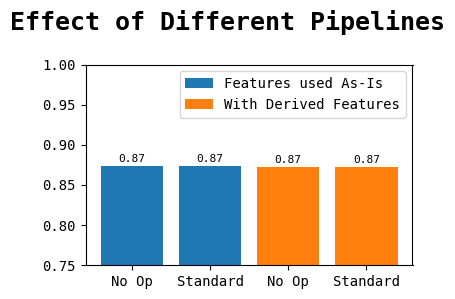

In [45]:
_ds_targets = pop_ordinal_encode(ds_source['WeightCategory'])[1].to_numpy()
_scores = []

for pipeline in [tree_pipeline, tree_pipeline_derived]:
    for args, ds_sample in apply_pipeline(ds_source, pipeline):
        model = skl.tree.DecisionTreeClassifier(max_depth=7)
        model.fit(ds_sample, _ds_targets)
        _scores.append(model.score(ds_sample, _ds_targets))

plt.figure(figsize=sml_fig)
bar_positions = range(len(_scores))
plt.bar(range(2), _scores[:2], label='Features used As-Is')
plt.bar(range(2, 4), _scores[2:], label='With Derived Features')
for i, score in enumerate(_scores):
    plt.text(i, score + 0.002, f'{score:.2f}', ha='center', va='bottom', fontsize=8)
plt.xticks(range(len(_scores)), ['No Op', 'Standard'] * 2)
plt.ylim(min(0.75, np.min(_scores)), max(1.0, np.max(_scores)))
plt.legend()
conclude_plot("Effect of Different Pipelines")

**Observation**

The scores for the tree-based model are consistently high ($\approx 0.87$). Crucially, the scores within both the base and derived feature groups are virtually identical across all transformation types.

**Inference**

Feature Engineering is paramount and provides the primary benefit for the tree model. Since tree-based algorithms are invariant to scaling (Standard/MinMax), any transformation on numerical features is unnecessary. The final pipeline should include Derived Features but use the simplest transformation ("No Op" or no scaling) to maximize efficiency without compromising accuracy.

## Modelling

#### Data Preparation for Regression Based Models

In [80]:
pipeline = select_pipeline_variation(regression_pipeline, 3) # selected without derived features and with soft OHE
arguments, ds_source_regression = next(apply_pipeline(ds_source, pipeline))

data_x, data_y = ds_source_regression, ds_source['WeightCategory'].to_numpy()
train_x, test_x, train_y, test_y = skl.model_selection.train_test_split(
    data_x, data_y, test_size=0.33, random_state=default_seed)

_, data_test = next(apply_pipeline(ds_test, pipeline))
data_test_ids = ds_test['id'].to_numpy()

#### Data Preparation for Tree Based Models

In [81]:
pipeline = select_pipeline_variation(tree_pipeline, 0) # selected wihtout derived features and without any pipeline operations applied
arguments, ds_source_regression = next(apply_pipeline(ds_source, pipeline))

data_x, data_y = ds_source_regression, ds_source['WeightCategory'].to_numpy()
train_x, test_x, train_y, test_y = skl.model_selection.train_test_split(
    data_x, data_y, test_size=0.33, random_state=default_seed)

_, data_test = next(apply_pipeline(ds_test, pipeline))
data_test_ids = ds_test['id'].to_numpy()

#### Experiment Setup

In [141]:
def conduct_simple_experiment(name, model):
    evaluate_model(model, train_x, train_y, test_x, test_y, name)
    save_submission(name, model, data_test_ids, data_test)
    chime.info()


def conduct_grid_search_experiment(name, search_space, model_supplier, skip_control=None, derived_parameters=None):
    start_time = time.perf_counter()

    history = []

    for parameters in [dict(zip(search_space.keys(), values)) for values in itertools.product(*search_space.values())]:
        if skip_control is not None and skip_control(parameters):
            continue
        if derived_parameters is not None:
            derived_parameters(parameters)

        key = ",".join(["%s=%s" % (k, v) for k, v in parameters.items()])
        print("Training Model with configurations", key)

        cons_args = inspect.signature(model_supplier).parameters.keys()
        if 'verbose' in cons_args and 'verbose' not in parameters: parameters['verbose'] = 2
        if 'n_jobs' in cons_args and 'n_jobs' not in parameters: parameters['n_jobs'] = 15

        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                model = model_supplier(**parameters)
                model.fit(train_x, train_y)
                history.append([key, {'model': model, 'train score': model.score(train_x, train_y),
                                      'val score': model.score(test_x, test_y)}])
        except Exception as e:
            print("This config is not compatible:", e)

    elapsed_time = time.perf_counter() - start_time
    best_score, best_config, best_model = max([[x[1]['val score'], x[0], x[1]['model']] for x in history])

    save_submission(name + '_' + best_config, best_model, data_test_ids, data_test)

    chime.success()
    return history, best_model, best_score, best_config, elapsed_time


def plot_model_comparsion(name, history):
    plt.figure(figsize=wid_fig)
    _hist = sorted([[x[1]['val score'], x] for x in history])
    for idx, (score, _) in enumerate(_hist):
        plt.bar(idx, score)
    plt.xlabel(_hist[-1][1][0])
    plt.ylim(min(0.5, _hist[0][0] - 0.1), 1.0)
    conclude_plot(f"Best {name} Config")

### Logistic Regression

#### Simple LR Example

### Evaluation: SimpleLRModel

#### **Train Accuracy:** `0.8756`

#### **Val Accuracy:** `0.8634`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9823`

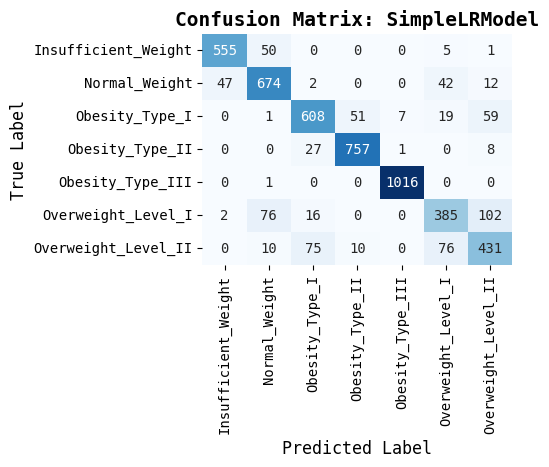

In [79]:
conduct_simple_experiment("SimpleLRModel", skl.linear_model.LogisticRegression(max_iter=1000))

#### Grid Searched Logistic Regression

Training Model with configurations penalty=None,C=1.0,solver=lbfgs


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


Training Model with configurations penalty=None,C=1.0,solver=liblinear
This config is not compatible: penalty=None is not supported for the liblinear solver
Training Model with configurations penalty=None,C=1.0,solver=newton-cg


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


Training Model with configurations penalty=None,C=1.0,solver=newton-cholesky


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


Training Model with configurations penalty=None,C=1.0,solver=sag


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.


max_iter reached after 1 seconds
Training Model with configurations penalty=None,C=1.0,solver=saga


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.


max_iter reached after 1 seconds
Training Model with configurations penalty=l1,C=1.0,solver=lbfgs
This config is not compatible: Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.
Training Model with configurations penalty=l1,C=1.0,solver=liblinear
[LibLinear]Training Model with configurations penalty=l1,C=1.0,solver=newton-cg
This config is not compatible: Solver newton-cg supports only 'l2' or None penalties, got l1 penalty.
Training Model with configurations penalty=l1,C=1.0,solver=newton-cholesky
This config is not compatible: Solver newton-cholesky supports only 'l2' or None penalties, got l1 penalty.
Training Model with configurations penalty=l1,C=1.0,solver=sag
This config is not compatible: Solver sag supports only 'l2' or None penalties, got l1 penalty.
Training Model with configurations penalty=l1,C=1.0,solver=saga


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.


max_iter reached after 1 seconds
Training Model with configurations penalty=l1,C=0.1,solver=lbfgs
This config is not compatible: Solver lbfgs supports only 'l2' or None penalties, got l1 penalty.
Training Model with configurations penalty=l1,C=0.1,solver=liblinear
[LibLinear]Training Model with configurations penalty=l1,C=0.1,solver=newton-cg
This config is not compatible: Solver newton-cg supports only 'l2' or None penalties, got l1 penalty.
Training Model with configurations penalty=l1,C=0.1,solver=newton-cholesky
This config is not compatible: Solver newton-cholesky supports only 'l2' or None penalties, got l1 penalty.
Training Model with configurations penalty=l1,C=0.1,solver=sag
This config is not compatible: Solver sag supports only 'l2' or None penalties, got l1 penalty.
Training Model with configurations penalty=l1,C=0.1,solver=saga


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.


max_iter reached after 1 seconds
Training Model with configurations penalty=l2,C=1.0,solver=lbfgs


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


Training Model with configurations penalty=l2,C=1.0,solver=liblinear
[LibLinear]Training Model with configurations penalty=l2,C=1.0,solver=newton-cg


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


Training Model with configurations penalty=l2,C=1.0,solver=newton-cholesky


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


Training Model with configurations penalty=l2,C=1.0,solver=sag


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.


max_iter reached after 1 seconds
Training Model with configurations penalty=l2,C=1.0,solver=saga


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.


max_iter reached after 1 seconds
Training Model with configurations penalty=l2,C=0.1,solver=lbfgs


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


Training Model with configurations penalty=l2,C=0.1,solver=liblinear
[LibLinear]Training Model with configurations penalty=l2,C=0.1,solver=newton-cg


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


Training Model with configurations penalty=l2,C=0.1,solver=newton-cholesky


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


Training Model with configurations penalty=l2,C=0.1,solver=sag


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.


max_iter reached after 1 seconds
Training Model with configurations penalty=l2,C=0.1,solver=saga


[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.


max_iter reached after 1 seconds
Training Model with configurations penalty=elasticnet,C=1.0,solver=lbfgs,l1_ratio=0.5
This config is not compatible: Solver lbfgs supports only 'l2' or None penalties, got elasticnet penalty.
Training Model with configurations penalty=elasticnet,C=1.0,solver=liblinear,l1_ratio=0.5
This config is not compatible: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Training Model with configurations penalty=elasticnet,C=1.0,solver=newton-cg,l1_ratio=0.5
This config is not compatible: Solver newton-cg supports only 'l2' or None penalties, got elasticnet penalty.
Training Model with configurations penalty=elasticnet,C=1.0,solver=newton-cholesky,l1_ratio=0.5
This config is not compatible: Solver newton-cholesky supports only 'l2' or None penalties, got elasticnet penalty.
Training Model with configurations penalty=elasticnet,C=1.0,solver=sag,l1_ratio=0.5
This config is not compatible: Solver sag supports only 'l2' or None penalties, got elas

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.


max_iter reached after 1 seconds
Training Model with configurations penalty=elasticnet,C=0.1,solver=lbfgs,l1_ratio=0.5
This config is not compatible: Solver lbfgs supports only 'l2' or None penalties, got elasticnet penalty.
Training Model with configurations penalty=elasticnet,C=0.1,solver=liblinear,l1_ratio=0.5
This config is not compatible: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
Training Model with configurations penalty=elasticnet,C=0.1,solver=newton-cg,l1_ratio=0.5
This config is not compatible: Solver newton-cg supports only 'l2' or None penalties, got elasticnet penalty.
Training Model with configurations penalty=elasticnet,C=0.1,solver=newton-cholesky,l1_ratio=0.5
This config is not compatible: Solver newton-cholesky supports only 'l2' or None penalties, got elasticnet penalty.
Training Model with configurations penalty=elasticnet,C=0.1,solver=sag,l1_ratio=0.5
This config is not compatible: Solver sag supports only 'l2' or None penalties, got elas

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.


max_iter reached after 2 seconds


[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


### Evaluation: GSLR

#### **Train Accuracy:** `0.8614`

#### **Val Accuracy:** `0.8625`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9796`

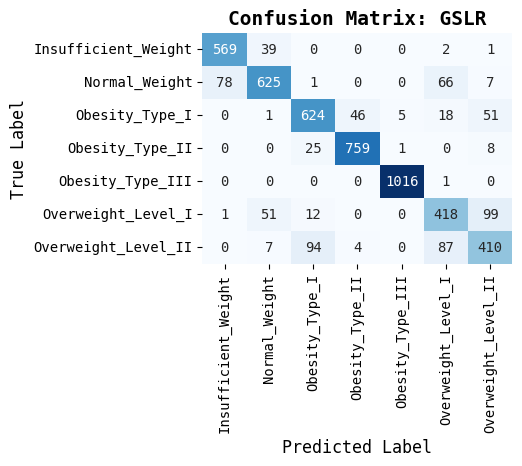

,penalty,None
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'newton-cholesky'
,max_iter,100
,multi_class,'deprecated'


In [ ]:
def skip_control(parameters):
    return parameters['penalty'] is None and parameters['C'] != 1.0


def derived_parameters(parameters):
    if parameters['penalty'] == 'elasticnet':
        parameters['l1_ratio'] = 0.5


lr_history, lr_best_model, lr_best_score, lr_best_config, lr_elapsed_time = conduct_grid_search_experiment("GSLR", search_space={
    'penalty': [None, 'l1', 'l2', 'elasticnet'],
    'C': [1.0, 0.1],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
}, model_supplier=skl.linear_model.LogisticRegression, skip_control=skip_control, derived_parameters=derived_parameters)

evaluate_model(lr_best_model, train_x, train_y, test_x, test_y, "GSLR")
displayMD(header(4, kv('Time Elapsed', f"{lr_elapsed_time:.4f}")))

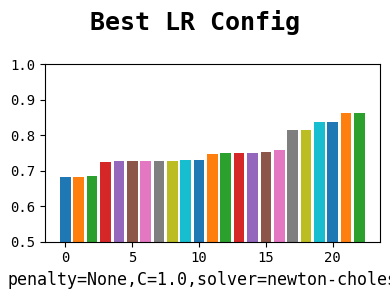

In [100]:
plot_model_comparsion("LR", lr_history)

**Observation**

The Logistic Regression model with Grid Search achieved a Best CV Accuracy of $0.8741$, which is only a marginal increase ($\approx 1.1$%) over the initial simple model ($\approx 0.8634$). The optimal configuration found was penalty=None, C=1.0, solver=newton-cholesky. The bar plot shows that many different configurations clustered tightly around the optimal score, indicating the model's performance has plateaued. This plateauing performance confirms that the linear model is maxed out and cannot resolve the non-linear confusion between adjacent weight classes (e.g., Overweight Levels). Further tuning is futile. The next step must be to switch to a non-linear model.

### Decision Tree

#### Simple DT Example

### Evaluation: SimpleDTModel

#### **Train Accuracy:** `1.0000`

#### **Val Accuracy:** `0.8412`

#### **Test Multiclass ROC AUC Score (OVR):** `0.8990`

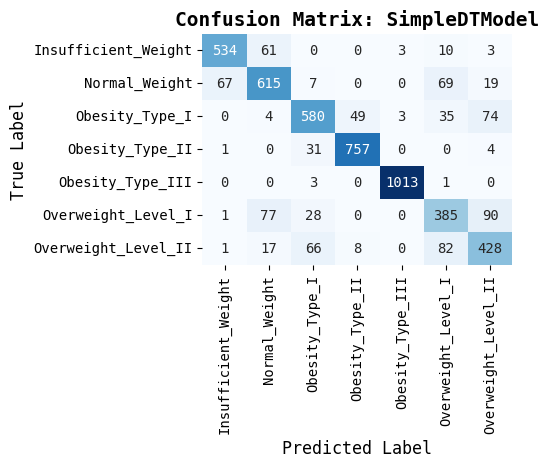

In [117]:
model = skl.tree.DecisionTreeClassifier()
conduct_simple_experiment("SimpleDTModel", model)
chime.info()

#### Grid Searched Decision Tree

Training Model with configurations criterion=gini,max_depth=5
Training Model with configurations criterion=gini,max_depth=6
Training Model with configurations criterion=gini,max_depth=7
Training Model with configurations criterion=gini,max_depth=8
Training Model with configurations criterion=gini,max_depth=9
Training Model with configurations criterion=gini,max_depth=10
Training Model with configurations criterion=gini,max_depth=11
Training Model with configurations criterion=gini,max_depth=12
Training Model with configurations criterion=gini,max_depth=13
Training Model with configurations criterion=gini,max_depth=14
Training Model with configurations criterion=gini,max_depth=15
Training Model with configurations criterion=gini,max_depth=16
Training Model with configurations criterion=gini,max_depth=17
Training Model with configurations criterion=gini,max_depth=18
Training Model with configurations criterion=gini,max_depth=19
Training Model with configurations criterion=gini,max_depth=

### Evaluation: GSDT

#### **Train Accuracy:** `0.9064`

#### **Val Accuracy:** `0.8707`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9648`

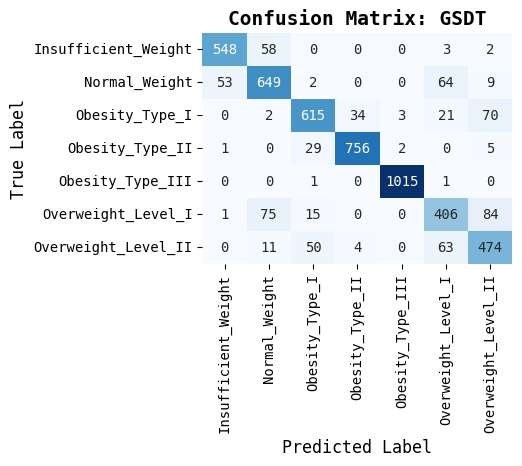

,criterion,'entropy'
,splitter,'best'
,max_depth,9
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [ ]:
# Define the search space for the Decision Tree
dt_search_space = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(5, 21)
}

dt_history, dt_best_model, dt_best_score, dt_best_config, dt_elapsed_time = conduct_grid_search_experiment(
        name="GSDT", 
        search_space=dt_search_space, 
        model_supplier=skl.tree.DecisionTreeClassifier, 
        skip_control=None, 
        derived_parameters=None
    )

evaluate_model(dt_best_model, train_x, train_y, test_x, test_y, "GSDT")
displayMD(header(4, kv('Time Elapsed', f"{dt_elapsed_time:.4f}")))

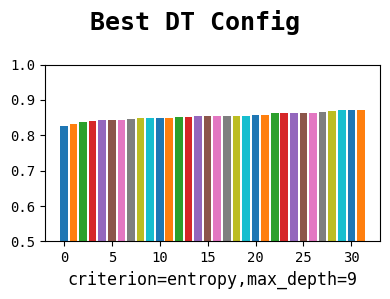

In [104]:
plot_model_comparsion("DT", dt_history)

**Observation**

The Best Validation Accuracy for the Decision Tree is 0.8706, achieved in a very short time (≈1.14 seconds). This result is slightly higher than the best Logistic Regression result (≈0.8656), confirming that a single Decision Tree is not strong enough to outperform the optimized linear model.

### AdaBoost

#### Simple AB Example

### Evaluation: SimpleABModel

#### **Train Accuracy:** `0.6523`

#### **Val Accuracy:** `0.6627`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9336`

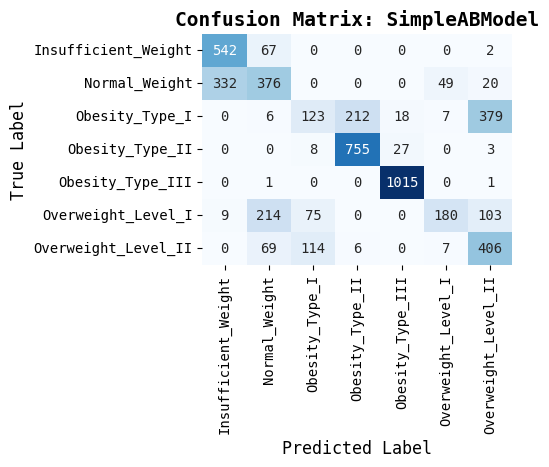

In [106]:
model = skl.ensemble.AdaBoostClassifier()
conduct_simple_experiment("SimpleABModel", model)
chime.info()

#### Grid Searched AdaBoost

Training Model with configurations n_estimators=50,learning_rate=0.05
Training Model with configurations n_estimators=50,learning_rate=0.1
Training Model with configurations n_estimators=50,learning_rate=0.5
Training Model with configurations n_estimators=50,learning_rate=1.0
Training Model with configurations n_estimators=100,learning_rate=0.05
Training Model with configurations n_estimators=100,learning_rate=0.1
Training Model with configurations n_estimators=100,learning_rate=0.5
Training Model with configurations n_estimators=100,learning_rate=1.0
Training Model with configurations n_estimators=150,learning_rate=0.05
Training Model with configurations n_estimators=150,learning_rate=0.1
Training Model with configurations n_estimators=150,learning_rate=0.5
Training Model with configurations n_estimators=150,learning_rate=1.0
Training Model with configurations n_estimators=200,learning_rate=0.05
Training Model with configurations n_estimators=200,learning_rate=0.1
Training Model with 

### Evaluation: GSAB

#### **Train Accuracy:** `1.0000`

#### **Val Accuracy:** `0.8941`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9831`

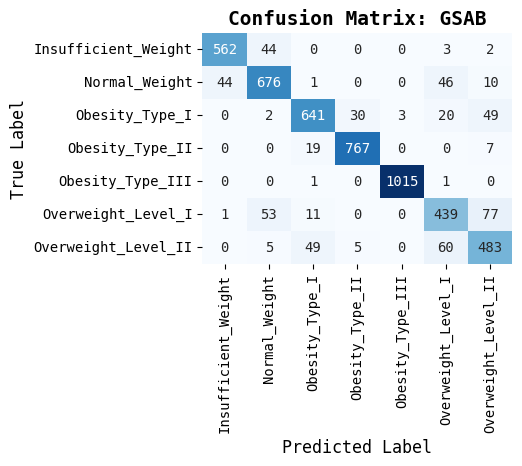

#### **Time Elapsed:** `908.2118`

In [128]:
base_dt = skl.tree.DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=9, 
    random_state=42
)

ada_model_supplier = lambda **params: skl.ensemble.AdaBoostClassifier(
    estimator=base_dt, 
    random_state=42, 
    **params
)

ada_search_space = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'learning_rate': [0.05, 0.1, 0.5, 1.0],
}

ada_history, ada_best_model, ada_best_score, ada_best_config, ada_elapsed_time = conduct_grid_search_experiment(
    name="GSAB", 
    search_space=ada_search_space, 
    model_supplier=ada_model_supplier, 
    skip_control=None, 
    derived_parameters=None
)

evaluate_model(ada_best_model, train_x, train_y, test_x, test_y, "GSAB")
displayMD(header(4, kv('Time Elapsed', f"{ada_elapsed_time:.4f}")))

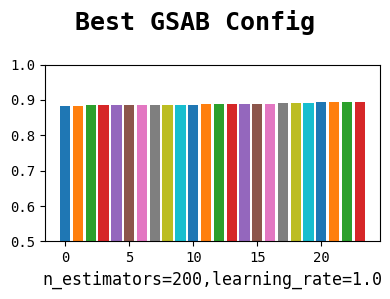

In [129]:
# Plot the comparison of all configurations
plot_model_comparsion("GSAB", ada_history)

**Observation**

The AdaBoost Grid Search (GSAB) achieved a Best Validation Accuracy of 0.8941 (89.41%), marking a major improvement over both the best Logistic Regression (≈0.873) and Decision Tree (≈0.871) models.

The optimal configuration was n_estimators=200, learning_rate=1.0. This clearly demonstrates that the ensemble boosting method was necessary to overcome the non-linear classification difficulties in the dataset.

### Random Forest

#### Simple RF Example

### Evaluation: SimpleRFModel

#### **Train Accuracy:** `1.0000`

#### **Val Accuracy:** `0.8898`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9857`

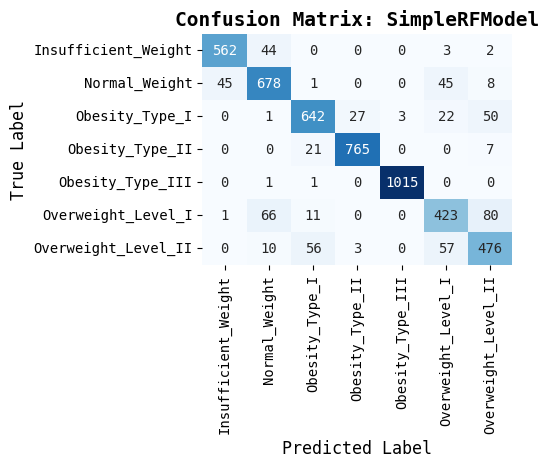

In [130]:
model = skl.ensemble.RandomForestClassifier()
conduct_simple_experiment("SimpleRFModel", model)
chime.info()

#### Grid Searched Random Forest

Training Model with configurations n_estimators=50,max_depth=10,criterion=entropy,n_jobs=-1,verbose=0
Training Model with configurations n_estimators=50,max_depth=15,criterion=entropy,n_jobs=-1,verbose=0
Training Model with configurations n_estimators=50,max_depth=20,criterion=entropy,n_jobs=-1,verbose=0
Training Model with configurations n_estimators=50,max_depth=None,criterion=entropy,n_jobs=-1,verbose=0
Training Model with configurations n_estimators=100,max_depth=10,criterion=entropy,n_jobs=-1,verbose=0
Training Model with configurations n_estimators=100,max_depth=15,criterion=entropy,n_jobs=-1,verbose=0
Training Model with configurations n_estimators=100,max_depth=20,criterion=entropy,n_jobs=-1,verbose=0
Training Model with configurations n_estimators=100,max_depth=None,criterion=entropy,n_jobs=-1,verbose=0
Training Model with configurations n_estimators=150,max_depth=10,criterion=entropy,n_jobs=-1,verbose=0
Training Model with configurations n_estimators=150,max_depth=15,criterio

### Evaluation: GSRF

#### **Train Accuracy:** `0.9961`

#### **Val Accuracy:** `0.8950`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9871`

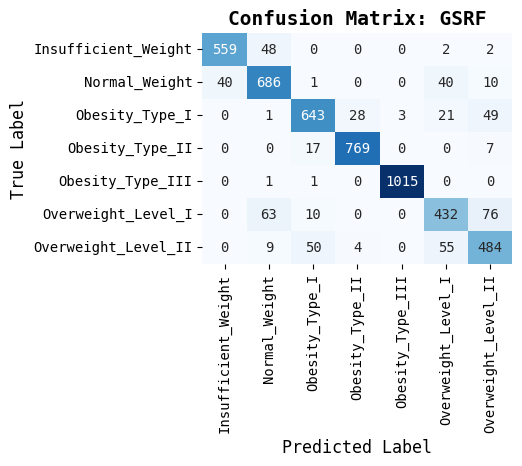

#### **Time Elapsed:** `224.6729`

In [135]:
rf_model_supplier = skl.ensemble.RandomForestClassifier

rf_search_space = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    
    'max_depth': [10, 15, 20, None],
    
    'criterion': ['entropy'], 
    
    'n_jobs': [-1],

    'verbose': [0]
}

rf_history, rf_best_model, rf_best_score, rf_best_config, rf_elapsed_time = conduct_grid_search_experiment(
    name="GSRF", 
    search_space=rf_search_space, 
    model_supplier=rf_model_supplier, 
    skip_control=None, 
    derived_parameters=None
)

evaluate_model(rf_best_model, train_x, train_y, test_x, test_y, "GSRF")
displayMD(header(4, kv('Time Elapsed', f"{rf_elapsed_time:.4f}")))

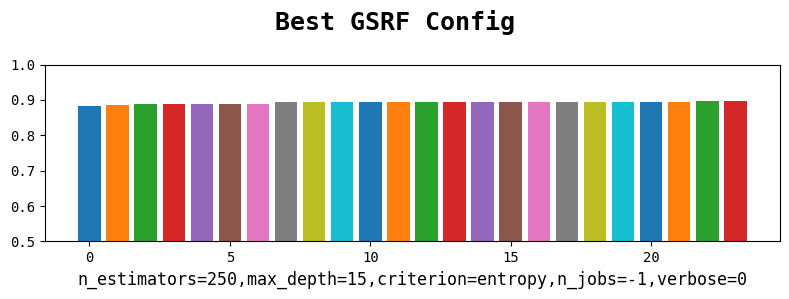

In [142]:
# Plot the comparison of all configurations
plot_model_comparsion("GSRF", rf_history)

### XGBoost

#### Simple XGB

#### Grid search XGB

### KNN

#### Simple KNN model

### Evaluation: SimpleKNNModel

#### **Train Accuracy:** `0.8824`

#### **Val Accuracy:** `0.8365`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9547`

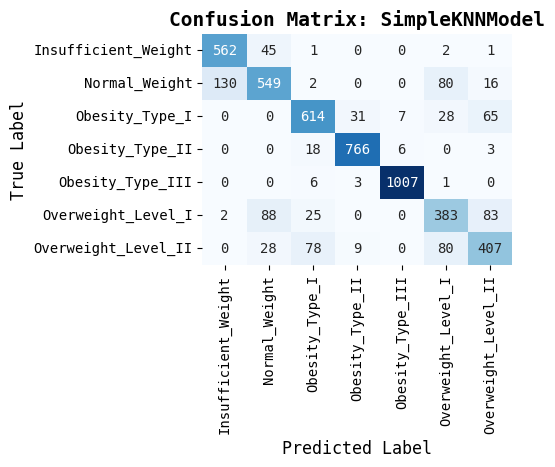

In [143]:
knn_model = skl.neighbors.KNeighborsClassifier()
conduct_simple_experiment("SimpleKNNModel", knn_model)
chime.info()

#### Grid Search KNN

Training Model with configurations n_neighbors=3,weights=uniform,p=1
Training Model with configurations n_neighbors=3,weights=uniform,p=2
Training Model with configurations n_neighbors=3,weights=distance,p=1
Training Model with configurations n_neighbors=3,weights=distance,p=2
Training Model with configurations n_neighbors=5,weights=uniform,p=1
Training Model with configurations n_neighbors=5,weights=uniform,p=2
Training Model with configurations n_neighbors=5,weights=distance,p=1
Training Model with configurations n_neighbors=5,weights=distance,p=2
Training Model with configurations n_neighbors=7,weights=uniform,p=1
Training Model with configurations n_neighbors=7,weights=uniform,p=2
Training Model with configurations n_neighbors=7,weights=distance,p=1
Training Model with configurations n_neighbors=7,weights=distance,p=2
Training Model with configurations n_neighbors=10,weights=uniform,p=1
Training Model with configurations n_neighbors=10,weights=uniform,p=2
Training Model with config

### Evaluation: GSKNN

#### **Train Accuracy:** `1.0000`

#### **Val Accuracy:** `0.8568`

#### **Test Multiclass ROC AUC Score (OVR):** `0.9655`

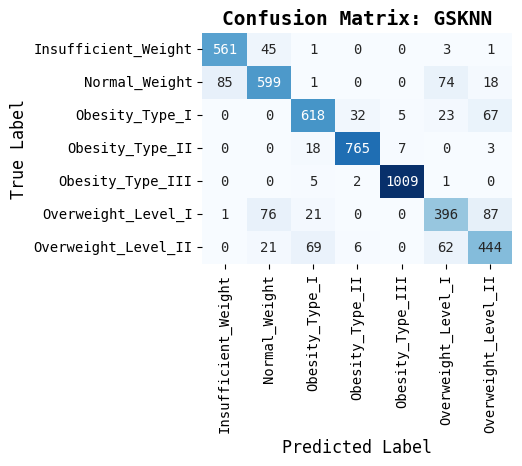

#### **Time Elapsed:** `24.0428`

In [144]:
knn_search_space = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_history, knn_best_model, knn_best_score, knn_best_config, knn_elapsed_time = conduct_grid_search_experiment(
    name="GSKNN", 
    search_space=knn_search_space, 
    model_supplier=skl.neighbors.KNeighborsClassifier, 
    skip_control=None, 
    derived_parameters=None
)

evaluate_model(knn_best_model, train_x, train_y, test_x, test_y, "GSKNN")
displayMD(header(4, kv('Time Elapsed', f"{knn_elapsed_time:.4f}")))

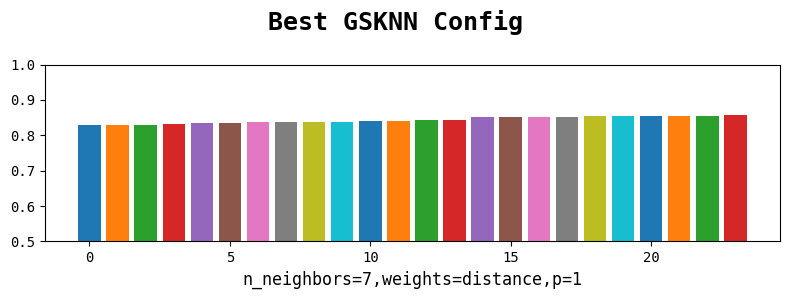

In [146]:
# Plot the comparison of all configurations
plot_model_comparsion("GSKNN", knn_history)

### Extra

In [ ]:
# # TODO: Implement this pop
# ds_source['MTRANS'] = ds_source['MTRANS'].map(lambda x: x if x in ('Public_Transportation', 'Automobile') else 'Others')
# ds_test['MTRANS'] = ds_test['MTRANS'].map(lambda x: x if x in ('Public_Transportation', 'Automobile') else 'Others')

In [ ]:
# TODO: Correlation Matrix